# Import Library

In [ ]:
# Import Libraries
import csv
import re
import string
from io import StringIO
import unicodedata

import pandas as pd
import requests

import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM, GRU, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Download packages
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\nurri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nurri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data Preparation

In [ ]:
# Read the CSV file into a DataFrame
df = pd.read_csv('reviews_shopee.csv')

In [ ]:
# Display the first five rows of the DataFrame
df.head()

,Review
0,saran saja. harusnya cantumkan nomor kurir unt...
1,"Semua sudah bagus, tapi maaf. Aplikasi atau we..."
2,Aplikasi ini sangat bagus dan mudah dalam peng...
3,"aplikasi udah gk berat lagi ,sudah lancar teta..."
4,selama belanja disini Alhamdulillah sih aman2 ...


In [ ]:
# Show summary information of the raw reviews DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72000 entries, 0 to 71999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  72000 non-null  object
dtypes: object(1)
memory usage: 562.6+ KB


# Data Preprocessing

In [ ]:
# Function to clean the text
def cleaning_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('ASCII')
    text = re.sub(r'[0-9]+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = text.replace('\n', ' ')
    text = ' '.join(text.split())
    text = text.strip()

    return text

In [ ]:
# Function to casefold the text
def casefolding_text(text):
    return text.lower()

In [ ]:
# Function to slangword the text
slangwords = {
    "lo": "kamu", "gue": "saya", "kaga": "tidak", "nggak": "tidak", "bgt": "banget", "ttg": "tentang", "gpp": "tidak apa-apa",
    "pls": "please", "omg": "oh my god", "lho": "loh", "gimana": "bagaimana", "gak": "tidak", "biasa aja": "biasa saja", "vocer": "voucer",
    "nambahin": "menambahkan", "fitur": "fitur", "update": "pembaruan", "fix": "perbaiki", "cari": "mencari", "original": "asli",
    "susah": "sulit", "bikin": "membuat", "mau": "ingin", "tunggu": "menunggu", "cepet": "cepat", "pdhl": "padahal",  "kw": "palsu",
    "benerin": "memperbaiki", "yg": "yang", "utk": "untuk", "sih": "ya", "spx": "layanan pengiriman", "lemot": "lambat", "pas": "tepat",
    "banyak": "banyak", "ongkir": "biaya pengiriman", "bosen": "bosan", "nyebelin": "menyebalkan", "kalau": "apabila", "real": "asli",
    "murahan": "harga rendah", "gampang": "mudah", "susah banget": "sulit sekali", "oke": "baik", "batal": "dibatalkan", "kl": "jika", "hp": "ponsel",
    "refund": "pengembalian dana", "nge-bug": "mengalami masalah", "not responding": "tidak merespon", "crash": "terhenti", "close": "keluar",
    "lag": "kesalahan respon sistem", "glitch": "kerusakan sistem", "worth it": "sebanding", "spam": "iklan", "fake": "palsu", "horrible": "mengerikan",
    "oke banget": "sangat baik", "payah": "buruk", "kritis": "penting", "mikir": "berpikir", "ngecharge": "mengisi daya", "minus": "kecacatan",
    "pecah": "sukses", "petir": "cepat", "instan": "cepat", "ngabisin": "menghabiskan", "ngetop": "terkenal", "caper": "mencari perhatian",
    "bikin stress": "membuat stres", "ngapain": "buat apa", "nobar": "nonton bareng", "galau": "bingung", "nangis": "menangis", "selow": "santai",
    "rempong": "ribet", "kece": "keren", "seru": "menyenangkan", "bro": "teman", "cewek": "perempuan", "cowok": "laki-laki", "temen": "teman",
    "ngumpul": "berkumpul", "mantul": "bagus sekali","pusing": "bingung", "emosi": "marah", "salfok": "fokus", "modifikasi": "mengubah",
    "belom": "belum", "gw": "saya", "masuk akal": "logis","cocok": "sesuai", "kapok": "menyesal", "mentah": "belum matang", "jago": "terampil",
    "ngikut": "ikut", "tanpa ragu": "yakin", "asik": "menyenangkan", "bos": "atasan", "nggak sabar": "tidak sabar", "nyantai": "santai",
    "langsung": "segera", "hype": "terkenal", "begini": "seperti ini", "semangat": "bersemangat", "bodo amat": "tidak peduli", "gila": "hebat",
    "gokil": "gila", "kocak": "lucu", "gaul": "populer", "kompak": "bersama", "untung": "keuntungan", "ngetren": "terkenal", "makin parah": "lebih buruk",
    "mundur": "berhenti", "jangan sampe": "jangan sampai", "enak banget": "sangat enak", "gimana dong": "bagaimana", "mending": "lebih baik",
    "bangga": "senang", "curhat": "cerita", "bengong": "melamun", "lagian": "lagi pula", "makasih": "terima kasih", "sayang": "cinta",
    "kuat": "teguh", "liat": "lihat", "capek": "lelah", "jatuh": "terjatuh", "cocok banget": "sangat sesuai", "tahan": "bertahan", "ngaret": "terlambat",
    "ngebut": "sangat cepat", "makin": "semakin", "kalo": "jika", "ongkir": "biaya pengiriman", "bosen": "bosan", "nyebelin": "menyebalkan", "mqu": "mau",
    "kitq": "kita", "tqmpilan": "tampilan", "zonk": "gagal", "d": "di", "seken": "detik", "popup": "notifikasi", "cs": "layanan pengguna", "app": "aplikasi",
    "ekspedisi": "layanan pengiriman", "COD": "bayar ditempat", "anteraja": "layanan pengiriman", "sicepat": "layanan pengiriman", "jnt": "layanan pengiriman",
    "spx express": "layanan pengiriman"
}

def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [ ]:
# Function to tokenize the text
def tokenizing_text(text):
    return word_tokenize(text)

In [ ]:
# Function to filter the text
def filtering_text(tokens):
    stop_words = set(stopwords.words('indonesian'))

    custom_stopwords = {
        'iya', 'yaa', 'gak', 'nya', 'na', 'sih', 'ku', 'di',
        'ga', 'ya', 'gaa', 'loh', 'kah', 'woi', 'woii', 'woy',
        'dan', 'atau', 'yang', 'tetapi', 'seperti', 'juga', 'sama',
        'tb', 'makasih', 'thanks', 'bagus', 'jelek', 'murah',
        'mahal', 'cepat', 'lama', 'lebih', 'sedikit', 'banyak',
        'satu', 'dua', 'tiga', 'saya', 'kamu', 'mereka', 'kita', 'dll',
        'aku', 'oh', 'ah', 'eh', 'bgt', 'kakak', 'bos', 'bisa', 'gimana'
    }

    filtered_tokens = [word for word in tokens if word.lower() not in stop_words and word.isalpha()]
    return filtered_tokens

In [ ]:
# Function to stemming the text
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming_text(text):
    if not isinstance(text, str):
        return ''

    words = text.split()

    stemmed_words = [stemmer.stem(word) for word in words if word.isalpha()]

    return ' '.join(stemmed_words)

In [ ]:
# Function to sentence the text
def to_sentence(tokens):
    return ' '.join(tokens)

In [ ]:
# Apply the functions to the DataFrame
def preprocessing_text(df):
    df['cleaning_text'] = df['Review'].apply(cleaning_text)
    df['casefolding_text'] = df['cleaning_text'].apply(casefolding_text)
    df['fix_slangwords'] = df['casefolding_text'].apply(fix_slangwords)
    df['tokenizing_text'] = df['fix_slangwords'].apply(tokenizing_text)
    df['filtering_text'] = df['tokenizing_text'].apply(filtering_text)
    df['clean_text'] = df['filtering_text'].apply(to_sentence)
    return df

df = preprocessing_text(df)

In [ ]:
# Show summary information of the cleaned DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72000 entries, 0 to 71999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Review            72000 non-null  object
 1   cleaning_text     72000 non-null  object
 2   casefolding_text  72000 non-null  object
 3   fix_slangwords    72000 non-null  object
 4   tokenizing_text   72000 non-null  object
 5   filtering_text    72000 non-null  object
 6   clean_text        72000 non-null  object
dtypes: object(7)
memory usage: 3.8+ MB


In [ ]:
# Display the first five rows of the DataFrame
df.head()

,Review,cleaning_text,casefolding_text,fix_slangwords,tokenizing_text,filtering_text,clean_text
0,saran saja. harusnya cantumkan nomor kurir unt...,saran saja harusnya cantumkan nomor kurir untu...,saran saja harusnya cantumkan nomor kurir untu...,saran saja harusnya cantumkan nomor kurir untu...,"[saran, saja, harusnya, cantumkan, nomor, kuri...","[saran, cantumkan, nomor, kurir, memudahkan, k...",saran cantumkan nomor kurir memudahkan komunik...
1,"Semua sudah bagus, tapi maaf. Aplikasi atau we...",Semua sudah bagus tapi maaf Aplikasi atau web ...,semua sudah bagus tapi maaf aplikasi atau web ...,semua sudah bagus tapi maaf aplikasi atau web ...,"[semua, sudah, bagus, tapi, maaf, aplikasi, at...","[bagus, maaf, aplikasi, web, kadang, lelet, lo...",bagus maaf aplikasi web kadang lelet loadingny...
2,Aplikasi ini sangat bagus dan mudah dalam peng...,Aplikasi ini sangat bagus dan mudah dalam peng...,aplikasi ini sangat bagus dan mudah dalam peng...,aplikasi ini sangat bagus dan mudah dalam peng...,"[aplikasi, ini, sangat, bagus, dan, mudah, dal...","[aplikasi, bagus, mudah, penggunaannya, fitur,...",aplikasi bagus mudah penggunaannya fitur menar...
3,"aplikasi udah gk berat lagi ,sudah lancar teta...",aplikasi udah gk berat lagi sudah lancar tetap...,aplikasi udah gk berat lagi sudah lancar tetap...,aplikasi udah gk berat lagi sudah lancar tetap...,"[aplikasi, udah, gk, berat, lagi, sudah, lanca...","[aplikasi, udah, gk, berat, lancar, sukaketika...",aplikasi udah gk berat lancar sukaketika buka ...
4,selama belanja disini Alhamdulillah sih aman2 ...,selama belanja disini Alhamdulillah sih aman a...,selama belanja disini alhamdulillah sih aman a...,selama belanja disini alhamdulillah ya aman aj...,"[selama, belanja, disini, alhamdulillah, ya, a...","[belanja, alhamdulillah, ya, aman, ajacara, pe...",belanja alhamdulillah ya aman ajacara pengemba...


# Data Transformation

In [ ]:
# Lexicon Positive
lexicon_positive = {}
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")

In [ ]:
# Lexicon negative
lexicon_negative = {}
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")

In [ ]:
# Calculate sentiment score and polarity from word list
def sentiment_analysis_lexicon_indonesia(text):
    score = 0

    for word in text:
        if word in lexicon_positive:
            score += lexicon_positive[word]
        if word in lexicon_negative:
            score += lexicon_negative[word]

    if score > 0:
        polarity = 'positif'
    elif score < 0:
        polarity = 'negatif'
    else:
        polarity = 'netral'

    return score, polarity

In [ ]:
# Apply sentiment analysis and add results to new columns
results = df['filtering_text'].apply(sentiment_analysis_lexicon_indonesia)

results = list(zip(*results))

df['polarity_score'] = results[0]
df['polarity'] = results[1]

print(df['polarity'].value_counts())

polarity
positif    34152
negatif    33513
netral      4335
Name: count, dtype: int64


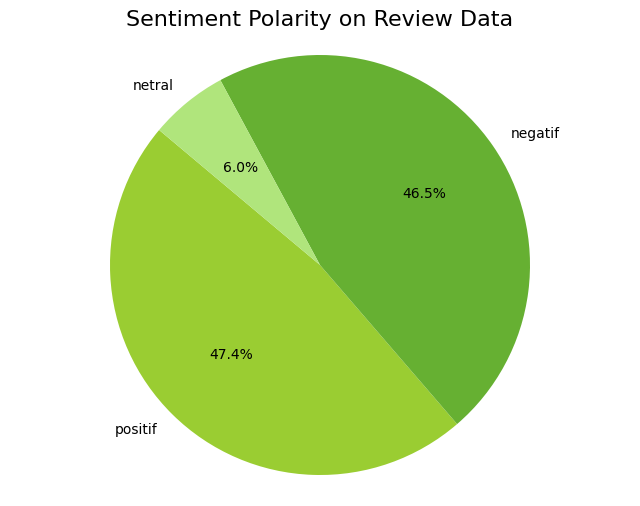

In [ ]:
# Visualize the sentiment polarity
polarity_counts = df['polarity'].value_counts()

labels = polarity_counts.index
sizes = polarity_counts.values

colors = ['#9acd32' if label == 'positif' else
          '#66b032' if label == 'negatif' else
          '#b0e57c' for label in labels]

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Polarity on Review Data', fontsize=16)
plt.axis('equal')
plt.show()

# Data Splitting

In [ ]:
# Data preparation and TF-IDF feature extraction for Machine Learning
df['label'] = df['polarity'].astype('category').cat.codes
y = df['label'].values
X = df['clean_text'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
# Data Preparation for Deep Learning
y_dl = pd.get_dummies(df['polarity']).values
X_dl = df['clean_text'].values

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_dl)
sequences = tokenizer.texts_to_sequences(X_dl)
max_length = 100
padded_sequences = pad_sequences(sequences, maxlen=max_length)

X_dl_train, X_dl_test, y_dl_train, y_dl_test = train_test_split(padded_sequences, y_dl, test_size=0.2, random_state=42)

# Training

#### Logistic Regression (LR)

In [ ]:
# Logistic Regression with TF-IDF for sentiment analysis
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

y_train_pred_lr = lr_model.predict(X_train_tfidf)
y_test_pred_lr = lr_model.predict(X_test_tfidf)

In [ ]:
# Evaluate the model
print(f"Logistic regression Training Accuracy: {accuracy_score(y_train, y_train_pred_lr):.4f}")
print(f"Logistic regression Testing Accuracy: {accuracy_score(y_test, y_test_pred_lr):.4f}")

print("\nClassification Report - Testing Set:")
print(classification_report(y_test, y_test_pred_lr, target_names=df['polarity'].astype(str).unique()))

Logistic regression Training Accuracy: 0.9220
Logistic regression Testing Accuracy: 0.9045

Classification Report - Testing Set:
              precision    recall  f1-score   support

     positif       0.89      0.96      0.92      9969
     negatif       0.83      0.07      0.13      1301
      netral       0.92      0.96      0.94     10330

    accuracy                           0.90     21600
   macro avg       0.88      0.66      0.67     21600
weighted avg       0.90      0.90      0.88     21600



#### Support Vector Machine (SVM)

In [ ]:
# Support Vector Machine (SVM) with TF-IDF for sentiment analysis
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train)

y_train_pred_svm = svm_model.predict(X_train_tfidf)
y_test_pred_svm = svm_model.predict(X_test_tfidf)

In [ ]:
# Evaluate the model
print(f"Support Vector Machine - Training Accuracy: {accuracy_score(y_train, y_train_pred_svm):.4f}")
print(f"Support Vector Machine - Testing Accuracy: {accuracy_score(y_test, y_test_pred_svm):.4f}")

print("\nClassification Report - Testing Set:")
print(classification_report(y_test, y_test_pred_svm, target_names=df['polarity'].astype(str).unique()))

Support Vector Machine - Training Accuracy: 0.9242
Support Vector Machine - Testing Accuracy: 0.9061

Classification Report - Testing Set:
              precision    recall  f1-score   support

     positif       0.90      0.96      0.93      9969
     negatif       0.77      0.05      0.10      1301
      netral       0.91      0.96      0.94     10330

    accuracy                           0.91     21600
   macro avg       0.86      0.66      0.65     21600
weighted avg       0.90      0.91      0.88     21600



## Deep Learning

In [ ]:
# Create callbacks
class AccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')
        if acc and val_acc and acc > 0.92 and val_acc > 0.92:
            print(f"\nAkurasi dan val_akurasi > 92% pada epoch {epoch+1}. Training dihentikan.")
            self.model.stop_training = True

#### Long Short Term Memory (LSTM)

In [ ]:
# LSTM model for sentiment analysis
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_length),
    LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
# Evaluate the model
history = model.fit(
    X_dl_train, y_dl_train,
    validation_data=(X_dl_test, y_dl_test),
    epochs=50,
    batch_size=64,
    callbacks=[AccuracyCallback()],
    verbose=1
)

Epoch 1/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 188s 205ms/step - accuracy: 0.7336 - loss: 0.6380 - val_accuracy: 0.8926 - val_loss: 0.2982
Epoch 2/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 177s 196ms/step - accuracy: 0.8938 - loss: 0.2922 - val_accuracy: 0.9060 - val_loss: 0.2573
Epoch 3/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 193s 215ms/step - accuracy: 0.9144 - loss: 0.2423 - val_accuracy: 0.9162 - val_loss: 0.2356
Epoch 4/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 196s 217ms/step - accuracy: 0.9285 - loss: 0.2018 - val_accuracy: 0.9084 - val_loss: 0.2699
Epoch 5/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.9358 - loss: 0.1810
Akurasi dan val_akurasi > 92% pada epoch 5. Training dihentikan.
900/900 ━━━━━━━━━━━━━━━━━━━━ 191s 212ms/step - accuracy: 0.9358 - loss: 0.1810 - val_accuracy: 0.9233 - val_loss: 0.2255


#### Convolutional Neural Network (CNN)

In [ ]:
# CNN model for sentiment analysis
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_length),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
# Evaluate the model
history = model.fit(
    X_dl_train, y_dl_train,
    validation_data=(X_dl_test, y_dl_test),
    epochs=50,
    batch_size=64,
    callbacks=[AccuracyCallback()],
    verbose=1
)

Epoch 1/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.7380 - loss: 0.6281 - val_accuracy: 0.8534 - val_loss: 0.3877
Epoch 2/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9003 - loss: 0.2855 - val_accuracy: 0.8712 - val_loss: 0.3577
Epoch 3/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9249 - loss: 0.2161 - val_accuracy: 0.8732 - val_loss: 0.3820
Epoch 4/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9400 - loss: 0.1737 - val_accuracy: 0.8765 - val_loss: 0.3974
Epoch 5/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9503 - loss: 0.1420 - val_accuracy: 0.8813 - val_loss: 0.4237
Epoch 6/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9644 - loss: 0.1005 - val_accuracy: 0.8687 - val_loss: 0.4775
Epoch 7/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9734 - loss: 0.0785 - val_accuracy: 0.8693 - val_loss: 0.4503
Epoch 8/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9792 - loss: 0.0647 - 

### Gated Recurrent Unit (GRU)

In [ ]:
# GRU model for sentiment analysis
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_length),
    GRU(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    GRU(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(3, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
# Evaluate the model
history = model.fit(
    X_dl_train, y_dl_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_dl_test, y_dl_test),
    callbacks=[AccuracyCallback()]
)

Epoch 1/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 153s 165ms/step - accuracy: 0.7234 - loss: 0.6641 - val_accuracy: 0.8952 - val_loss: 0.2906
Epoch 2/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 146s 163ms/step - accuracy: 0.8954 - loss: 0.2895 - val_accuracy: 0.9072 - val_loss: 0.2525
Epoch 3/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 145s 161ms/step - accuracy: 0.9119 - loss: 0.2448 - val_accuracy: 0.8988 - val_loss: 0.2783
Epoch 4/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9244 - loss: 0.2097
Akurasi dan val_akurasi > 92% pada epoch 4. Training dihentikan.
900/900 ━━━━━━━━━━━━━━━━━━━━ 146s 162ms/step - accuracy: 0.9244 - loss: 0.2097 - val_accuracy: 0.9201 - val_loss: 0.2289


## Inference

In [ ]:
# Test the model with a sample text
label_mapping = {0: 'negatif', 1: 'netral', 2: 'positif'}

def predict_sentiment(text):
    cleaned = cleaning_text(text)
    folded = casefolding_text(cleaned)
    fixed = fix_slangwords(folded)
    tokens = tokenizing_text(fixed)
    filtered = filtering_text(tokens)
    stemmed = stemming_text(' '.join(filtered))

    sequence = tokenizer.texts_to_sequences([stemmed])
    padded = pad_sequences(sequence, maxlen=max_length)

    prediction = model.predict(padded)
    predicted_label_index = prediction.argmax(axis=1)[0]
    sentiment = label_mapping[predicted_label_index]

    return sentiment

input_text = input("Enter a new sentence: ")
hasil = predict_sentiment(input_text)
print(f"Sentimen: {hasil}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Sentimen: negatif
